In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import mean_squared_error
import warnings


In [2]:
series=pd.read_csv("airline-passengers.csv",header=0, index_col=0,parse_dates=True, squeeze=True )

In [3]:
series.isnull().sum()

0

In [4]:
series.describe()

count    144.000000
mean     280.298611
std      119.966317
min      104.000000
25%      180.000000
50%      265.500000
75%      360.500000
max      622.000000
Name: Passengers, dtype: float64

1) 

In [5]:
temps = pd.DataFrame(series.values)
window = temps.expanding()
df = pd.concat([window.min(), window.mean(), window.max(), temps.shift(-1)], axis=1)
df.columns = ['min', 'mean', 'max', 't+1']
print(df.head(5))

     min        mean    max    t+1
0  112.0  112.000000  112.0  118.0
1  112.0  115.000000  118.0  132.0
2  112.0  120.666667  132.0  129.0
3  112.0  122.750000  132.0  121.0
4  112.0  122.400000  132.0  135.0


In [6]:
df

,min,mean,max,t+1
0,112.0,112.000000,112.0,118.0
1,112.0,115.000000,118.0,132.0
2,112.0,120.666667,132.0,129.0
3,112.0,122.750000,132.0,121.0
4,112.0,122.400000,132.0,135.0
...,...,...,...,...
139,104.0,275.514286,622.0,508.0
140,104.0,277.163121,622.0,461.0
141,104.0,278.457746,622.0,390.0
142,104.0,279.237762,622.0,432.0


Expanding window has been used because we have limited data points

2) 

In [7]:
df.dropna(inplace=True)

In [8]:
df

,min,mean,max,t+1
0,112.0,112.000000,112.0,118.0
1,112.0,115.000000,118.0,132.0
2,112.0,120.666667,132.0,129.0
3,112.0,122.750000,132.0,121.0
4,112.0,122.400000,132.0,135.0
...,...,...,...,...
138,104.0,273.136691,622.0,606.0
139,104.0,275.514286,622.0,508.0
140,104.0,277.163121,622.0,461.0
141,104.0,278.457746,622.0,390.0


3) 

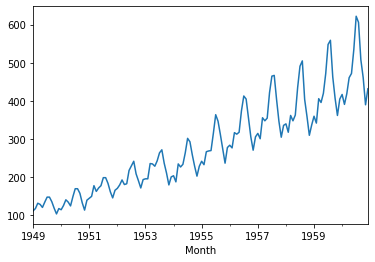

In [9]:
series.plot()
plt.show()

The plot shows that there is an increasing trend and have a clear seasonal pattern. The series is not a white series because the mean of the series is not zero.

The series is not a random walk because proceeding values are not a modification of previous values.

4)

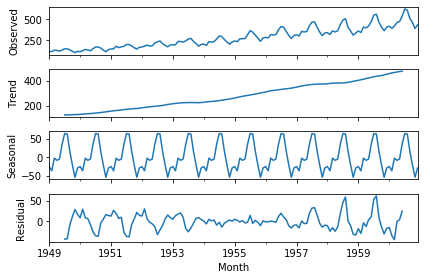

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(series, freq=12)
result.plot()
plt.show()


1. There is a clear increasing trend
2. Seasonlity is constant

5) 

In [11]:
X=series.values
result=adfuller(X)
print('ADF Statistic: %f'%result[0])
print('p-value : %f'%result[1])
print(' Citical Values:')
for key , value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.815369
p-value : 0.991880
 Citical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


Differencing needs to be performed because the series is not stationary

6)

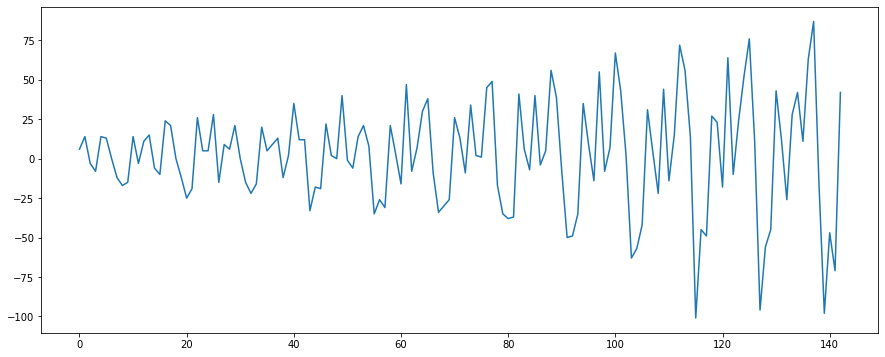

In [12]:
X=series.values
diff=list()
for i in range(1, len(X)):
    value = X[i] - X[i - 1]
    diff.append(value)

plt.figure(figsize=(15,6))
plt.plot(diff)
plt.show()



In [13]:
result=adfuller(diff)
print('ADF Statistic: %f'%result[0])
print('p-value : %f'%result[1])
print(' Citical Values:')
for key , value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.829267
p-value : 0.054213
 Citical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


Seasonality has not been completely handled via first order differencing. There is a need to perform 2nd order differencing. 

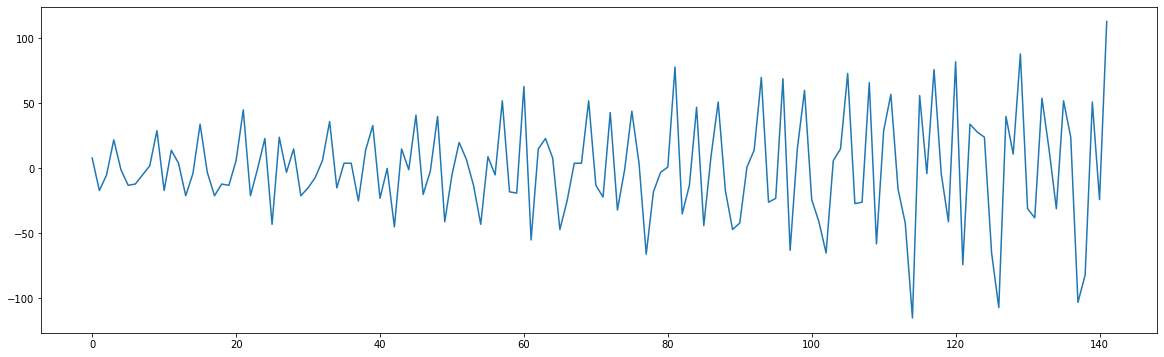

In [14]:
diff2=list()
for i in range(1, len(diff)):
    value = diff[i] - diff[i - 1]
    diff2.append(value)

plt.figure(figsize=(20,6))
plt.plot(diff2)
plt.show()

In [15]:
result=adfuller(diff2)
print('ADF Statistic: %f'%result[0])
print('p-value : %f'%result[1])
print(' Citical Values:')
for key , value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -16.384232
p-value : 0.000000
 Citical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


7) 

In [16]:
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
print(dataframe.head(5))
X = dataframe.values
train, test = X[1:len(X)-5], X[len(X)-5:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
len(test)

       t  t+1
0    NaN  112
1  112.0  118
2  118.0  132
3  132.0  129
4  129.0  121


5

In [17]:
def model_persistence(x):
    return x

In [18]:
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
rmse = np.sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 61.439


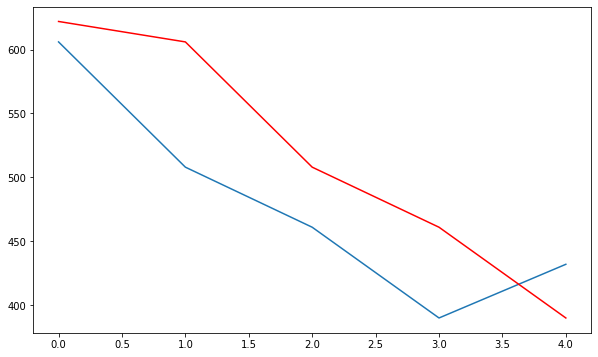

In [19]:
plt.figure(figsize=(10,6))
plt.plot(test_y)
plt.plot(predictions, color='red')
plt.show()

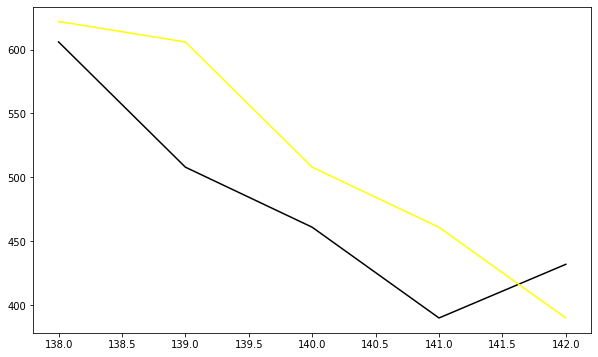

In [20]:
plt.figure(figsize=(10,6))
plt.plot([None for i in train_y] + [x for x in test_y],color='black')
plt.plot([None for i in train_y] + [x for x in predictions],color='yellow')
plt.show()


8) 

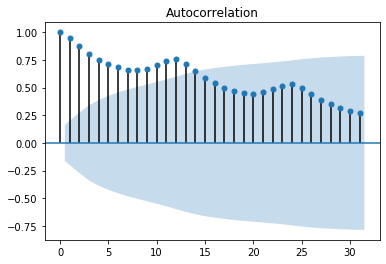

In [21]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(series, lags=31)
plt.show()

In [22]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
X = series.values
train, test = X[1:len(X)-5], X[len(X)-5:]
# train autoregression
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Lag: 13
Coefficients: [ 4.0289714   0.80312813 -0.12401078  0.0491418  -0.02137934  0.06739107
 -0.09985624  0.06409154 -0.08775045  0.12517872 -0.14190302  0.17541086
  0.8846458  -0.67413222]
predicted=624.816205, expected=606.000000
predicted=526.068728, expected=508.000000
predicted=452.647818, expected=461.000000
predicted=408.115140, expected=390.000000
predicted=450.808541, expected=432.000000
Test RMSE: 16.925


9) 

In [23]:
from statsmodels.tsa.ar_model import AR

In [24]:
X=dataframe.values
train_size=int(len(X)*0.66)
train, test=X[1:train_size], X[train_size:]
train_X, train_y=train[:,0],train[:,1]
test_X,test_y=test[:,0],test[:,1]

In [25]:
# persistence model on training set
train_pred = [x for x in train_X]
# calculate residuals
train_resid = [train_y[i]-train_pred[i] for i in range(len(train_pred))]
# model the training set residuals
model = AR(train_resid)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params
print('Lag=%d, Coef=%s' % (window, coef))

Lag=12, Coef=[ 6.73096433 -0.15858052 -0.24789727 -0.19155056 -0.26996064 -0.17048485
 -0.23497743 -0.21772851 -0.30489576 -0.18296949 -0.30251053 -0.11015227
  0.74668214]


In [26]:
# walk forward over time steps in test
history = train_resid[len(train_resid)-window:]
history = [history[i] for i in range(len(history))]


In [27]:
history

[41.0, 6.0, -7.0, 40.0, -4.0, 5.0, 56.0, 39.0, -8.0, -50.0, -49.0, -35.0]

predicted error=41.240605, expected error=35.000000
predicted error=5.106159, expected error=9.000000
predicted error=-7.939508, expected error=-14.000000
predicted error=37.966942, expected error=55.000000
predicted error=-6.500414, expected error=-8.000000
predicted error=10.018775, expected error=7.000000
predicted error=62.736883, expected error=67.000000
predicted error=38.471056, expected error=43.000000
predicted error=-13.835069, expected error=2.000000
predicted error=-57.977843, expected error=-63.000000
predicted error=-62.085086, expected error=-57.000000
predicted error=-38.848819, expected error=-42.000000
predicted error=36.204314, expected error=31.000000
predicted error=6.073424, expected error=4.000000
predicted error=-13.047671, expected error=-22.000000
predicted error=53.175872, expected error=44.000000
predicted error=-5.147055, expected error=-14.000000
predicted error=21.853543, expected error=15.000000
predicted error=80.104356, expected error=72.000000
predict

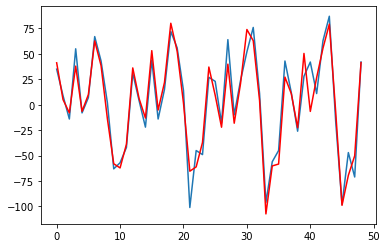

In [28]:
# walk forward over time steps in test
history = train_resid[len(train_resid)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
expected_error = list()
for t in range(len(test_y)):
# persistence
    yhat = test_X[t]
    error = test_y[t] - yhat
    expected_error.append(error)
# predict error
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    pred_error = coef[0]
    for d in range(window):
        pred_error += coef[d+1] * lag[window-d-1]
    predictions.append(pred_error)
    history.append(error)
    print('predicted error=%f, expected error=%f' % (pred_error, error))
# plot predicted error
plt.plot(expected_error)
plt.plot(predictions, color='red')
plt.show()

predicted error=41.240605, expected error=35.000000
predicted error=5.106159, expected error=9.000000
predicted error=-7.939508, expected error=-14.000000
predicted error=37.966942, expected error=55.000000
predicted error=-6.500414, expected error=-8.000000
predicted error=10.018775, expected error=7.000000
predicted error=62.736883, expected error=67.000000
predicted error=38.471056, expected error=43.000000
predicted error=-13.835069, expected error=2.000000
predicted error=-57.977843, expected error=-63.000000
predicted error=-62.085086, expected error=-57.000000
predicted error=-38.848819, expected error=-42.000000
predicted error=36.204314, expected error=31.000000
predicted error=6.073424, expected error=4.000000
predicted error=-13.047671, expected error=-22.000000
predicted error=53.175872, expected error=44.000000
predicted error=-5.147055, expected error=-14.000000
predicted error=21.853543, expected error=15.000000
predicted error=80.104356, expected error=72.000000
predict

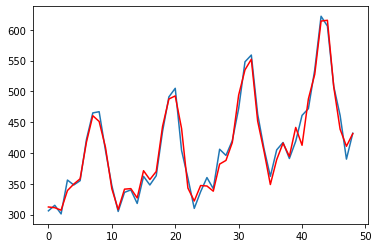

In [29]:
# walk forward over time steps in test
history = train_resid[len(train_resid)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
expected_error = list()
for t in range(len(test_y)):
# persistence
    yhat = test_X[t]
    error = test_y[t] - yhat
    expected_error.append(error)
# predict error
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    pred_error = coef[0]
    for d in range(window):
        pred_error += coef[d+1] * lag[window-d-1]
    # correct the prediction
    yhat = yhat + pred_error
    predictions.append(yhat)
    history.append(error)
    print('predicted error=%f, expected error=%f' % (pred_error, error))
rmse = np.sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)
# plot predicted error
plt.plot(test_y)
plt.plot(predictions, color='red')
plt.show()

10) 

<Figure size 720x432 with 0 Axes>

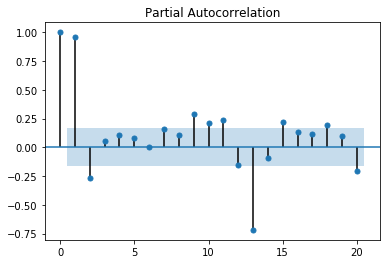

In [30]:
plt.figure(figsize=(10,6))
plot_pacf(series,lags=20)
plt.show()

E:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
E:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:           D.Passengers   No. Observations:                  143
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -660.388
Method:                       css-mle   S.D. of innovations             23.754
Date:                Sat, 08 May 2021   AIC                           1336.776
Time:                        23:39:04   BIC                           1360.478
Sample:                    02-01-1949   HQIC                          1346.407
                         - 12-01-1960                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.5782      0.775      3.325      0.001       1.059       4.098
ar.L1.D.Passengers     0.9661      0.100      9.614      0.000       0.769       1.163
ar.L2.D.Passengers  

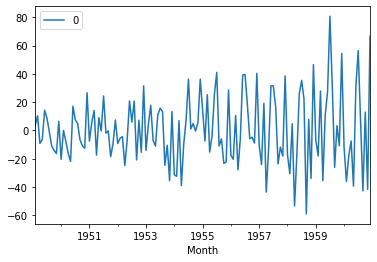

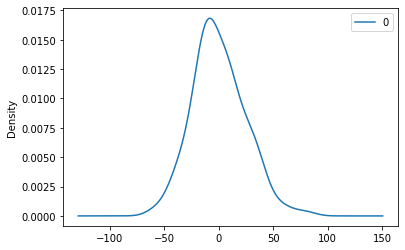

                0
count  143.000000
mean     0.314022
std     24.164594
min    -59.050885
25%    -15.911749
50%     -3.942038
75%     14.162702
max     80.705448


In [31]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(series, order=(3,1,3))
model_fit = model.fit(disp=0)
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [32]:
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]

predicted=274.717204, expected=306.000000
predicted=332.352432, expected=315.000000
predicted=343.638662, expected=301.000000
predicted=312.319334, expected=356.000000
predicted=369.395884, expected=348.000000
predicted=331.073610, expected=355.000000
predicted=367.903445, expected=422.000000
predicted=416.408123, expected=465.000000
predicted=444.255423, expected=467.000000
predicted=437.442204, expected=404.000000
predicted=370.654108, expected=347.000000
predicted=343.969081, expected=305.000000
predicted=294.902236, expected=336.000000
predicted=357.687585, expected=340.000000
predicted=361.304541, expected=318.000000
predicted=335.782689, expected=362.000000
predicted=379.794863, expected=348.000000
predicted=342.634406, expected=363.000000
predicted=382.504745, expected=435.000000
predicted=438.848717, expected=491.000000
predicted=477.150268, expected=505.000000
predicted=475.964507, expected=404.000000
predicted=350.160556, expected=359.000000
predicted=334.091654, expected=310

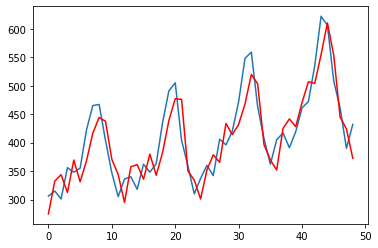

In [33]:

predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,3))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

11) How do ARIMA, MA and AR compare with baseline? How do they compare with each other? Which approach is the best?

The base model(persistence model) is performing worst with a RMS of 61.439. Second worst if ARIMA with RMSE of 37.702. AR and MA models have RMSE 16.925 and 13.897 respectively. Hence MA model is performing best